## Indian Language Identification from Speech

This notebook trains a model to identify spoken Indian languages using a dataset from your Google Drive.

In [1]:
#@title 1. Setup and Install Dependencies
#@markdown Run this cell first to install all necessary libraries.
#@markdown
#@markdown **IMPORTANT: After this cell completes, you MUST restart the runtime by clicking `Runtime -> Restart runtime` in the menu above before running any other cells.**


print("Installing all required libraries...")
!pip install librosa pydub tensorflow numpy scikit-learn matplotlib tqdm
!pip install resampy


try:
    import resampy
    import librosa
    print("\n✅ All libraries seem to be installed correctly.")
    print("Please RESTART THE RUNTIME now before proceeding.")
except ImportError as e:
    print(f"\n❌ ERROR: A library is missing: {e}")
    print("Please ensure the installation above completed without errors.")

Installing all required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.6 MB/s eta 0:00:00

✅ All libraries seem to be installed correctly.
Please RESTART THE RUNTIME now before proceeding.


In [1]:
#@title 2. Prepare Dataset from Google Drive
#@markdown **IMPORTANT: Only run this cell AFTER you have run the cell above and restarted the runtime.**


import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# --- Mount Google Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# --- Parameters for Google Drive Dataset ---
# Point this to the 'extracted_audio' folder in your Google Drive
DRIVE_BASE_PATH = '/content/drive/My Drive/extracted_audio'

# Mapping from your folder names to the language names the script will use
LANGUAGE_FOLDER_MAP = {
    "Audio_hi": "hindi",
    "Audio_ml": "malayalam",
    "Audio_mr": "marathi",
    "Audio_pa": "punjabi"
}
TARGET_LANGUAGES = list(LANGUAGE_FOLDER_MAP.values())


if not os.path.exists(DRIVE_BASE_PATH):
    raise FileNotFoundError(
        f"ERROR: The directory '{DRIVE_BASE_PATH}' was not found in your Google Drive. "
        "Please check the path and folder name and try again."
    )
else:
    print("Dataset successfully located in Google Drive.")


SAMPLE_RATE = 22050
DURATION = 5
N_MFCC = 20

def extract_features(file_path):
    """Loads an audio file and extracts MFCCs, padding/truncating to a fixed length."""
    try:

        audio, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')


        target_length = DURATION * sample_rate
        if len(audio) > target_length:
            audio = audio[:target_length]
        else:
            audio = np.pad(audio, (0, target_length - len(audio)), 'constant')


        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=N_MFCC)
        return mfccs
    except Exception as e:

        print(f"Error processing {file_path}: {e}")
        return None


all_features = []
all_labels = []

print("\nProcessing audio files from your Google Drive...")

for folder_name, language_label in LANGUAGE_FOLDER_MAP.items():
    lang_dir = os.path.join(DRIVE_BASE_PATH, folder_name)
    if os.path.isdir(lang_dir):
        print(f"Processing files for '{language_label}' from folder '{folder_name}'...")
        file_list = sorted(os.listdir(lang_dir))
        for file_name in tqdm(file_list): # Added a progress bar

            if file_name.lower().endswith(('.wav', '.mp3', '.flac')):
                file_path = os.path.join(lang_dir, file_name)
                features = extract_features(file_path)
                if features is not None:
                    all_features.append(features)
                    all_labels.append(language_label)
    else:
        print(f"Warning: Directory not found for {language_label}: {lang_dir}")


print(f"\nProcessed {len(all_features)} audio files from {len(TARGET_LANGUAGES)} languages.")
print("Features extracted successfully.")


X = np.array(all_features)
y = np.array(all_labels)


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


print("\nLanguage to ID mapping:")
for i, lang in enumerate(label_encoder.classes_):
    print(f"{lang}: {i}")


X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

print(f"\nData shapes:")
print(f"Training features: {X_train.shape}")
print(f"Validation features: {X_val.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Validation labels: {y_val.shape}")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.
Dataset successfully located in Google Drive.

Processing audio files from your Google Drive...
Processing files for 'hindi' from folder 'Audio_hi'...


  0%|          | 0/500 [00:00<?, ?it/s]

Processing files for 'malayalam' from folder 'Audio_ml'...


  0%|          | 0/500 [00:00<?, ?it/s]

Processing files for 'marathi' from folder 'Audio_mr'...


  0%|          | 0/500 [00:00<?, ?it/s]

Processing files for 'punjabi' from folder 'Audio_pa'...


  0%|          | 0/500 [00:00<?, ?it/s]


Processed 2000 audio files from 4 languages.
Features extracted successfully.

Language to ID mapping:
hindi: 0
malayalam: 1
marathi: 2
punjabi: 3

Data shapes:
Training features: (1600, 20, 216, 1)
Validation features: (400, 20, 216, 1)
Training labels: (1600,)
Validation labels: (400,)


In [23]:
#@title 3. Build the Language Identification Model
#@markdown This cell defines the model architecture.
#@markdown We use a Convolutional Recurrent Neural Network (CRNN).
#@markdown - **CNN layers** learn spatial features from the MFCCs.
#@markdown - **RNN (GRU) layer** learns temporal dependencies in the audio sequence.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    Reshape, GRU, Dense, Dropout, Bidirectional
)

def build_crnn_model(input_shape, num_classes):
    """Builds and compiles the CRNN model."""
    model = Sequential()


    model.add(Input(shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))


    last_shape = model.output_shape

    model.add(Dropout(0.25))


    new_shape = (last_shape[2], last_shape[1] * last_shape[3])
    model.add(Reshape(new_shape))


    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(GRU(128, return_sequences=False)))
    model.add(Dropout(0.3))


    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)


model = build_crnn_model(input_shape, num_classes)


model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 20, 216, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 20, 216, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 10, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 10, 108, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 108, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 54, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 5, 54, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 5, 54, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 5, 54, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 2, 27, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2, 27, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 1, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 13, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 13, 512)        │       789,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 13, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             

 Total params: 1,901,316 (7.25 MB)

 Trainable params: 1,900,164 (7.25 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [24]:
#@title 4. Train the Model
#@markdown This cell trains the model on the prepared data.
#@markdown We use callbacks to stop training early if performance doesn't improve
#@markdown and to reduce the learning rate on a plateau.

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


EPOCHS = 50
BATCH_SIZE = 32


print("\nStarting model training...")
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)
print("\nTraining finished.")


Starting model training...
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 824ms/step - accuracy: 0.3004 - loss: 1.4896 - val_accuracy: 0.3150 - val_loss: 1.3675 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 816ms/step - accuracy: 0.3705 - loss: 1.3174 - val_accuracy: 0.3900 - val_loss: 1.3728 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 809ms/step - accuracy: 0.5185 - loss: 1.1363 - val_accuracy: 0.4600 - val_loss: 1.1760 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 809ms/step - accuracy: 0.5585 - loss: 1.0026 - val_accuracy: 0.4575 - val_loss: 1.2870 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 783ms/step - accuracy: 0.5935 - loss: 0.9811 - val_accuracy: 0.4900 - val_loss: 1.1529 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 794ms/step - accuracy: 0.6024 - loss: 0.9293 - val_accuracy: 0.5825 - val_loss: 0.9112 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 791ms/step -

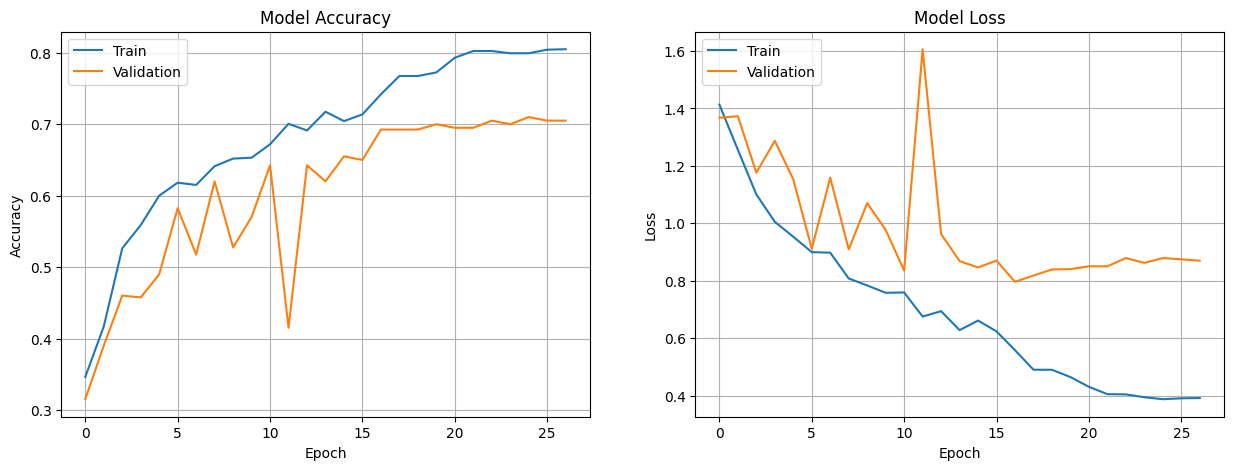


Evaluating model on validation data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step


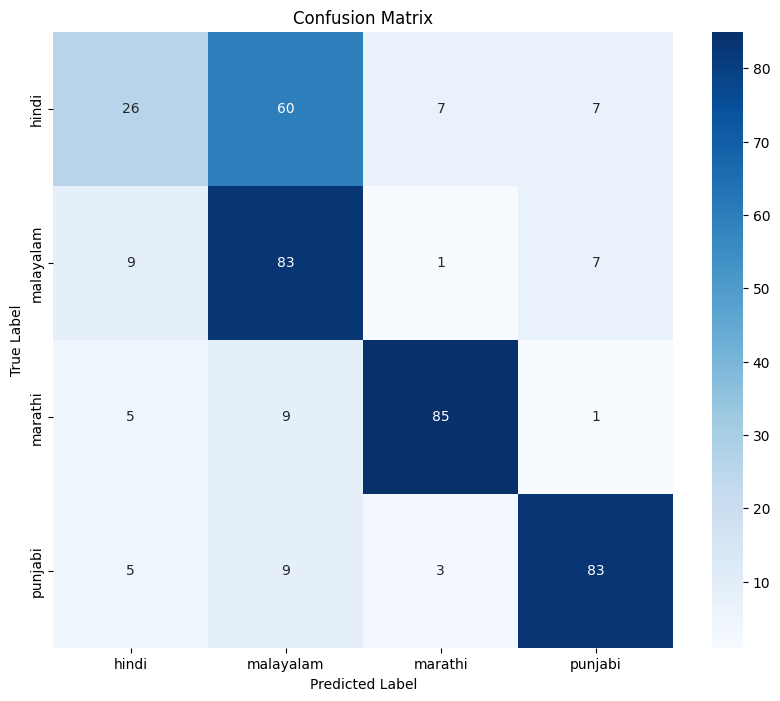


Classification Report:
              precision    recall  f1-score   support

       hindi       0.58      0.26      0.36       100
   malayalam       0.52      0.83      0.64       100
     marathi       0.89      0.85      0.87       100
     punjabi       0.85      0.83      0.84       100

    accuracy                           0.69       400
   macro avg       0.71      0.69      0.68       400
weighted avg       0.71      0.69      0.68       400



In [25]:
#@title 5. Evaluate Model Performance
#@markdown This cell visualizes the training history and shows detailed performance metrics.

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)



ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.grid(True)

plt.show()


print("\nEvaluating model on validation data...")
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)


cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

In [26]:
#@title 6. Interactive Prediction Functions
#@markdown Run this cell to define the prediction functions.
#@markdown This cell itself does not perform any prediction, it just makes the functions available for the next cells.

from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import io

def predict_language(audio_path):
    """
    Takes an audio file path, processes it, and predicts the language.
    """
    print(f"Predicting language for: {audio_path}")

    mfccs = extract_features(audio_path)

    if mfccs is None:
        print("Could not process audio file.")
        return


    mfccs_reshaped = mfccs[np.newaxis, ..., np.newaxis]


    prediction_probs = model.predict(mfccs_reshaped)
    predicted_index = np.argmax(prediction_probs)
    predicted_language = label_encoder.inverse_transform([predicted_index])[0]
    confidence = np.max(prediction_probs) * 100


    print(f"\n--- Prediction Result ---")
    print(f"Predicted Language: **{predicted_language.capitalize()}**")
    print(f"Confidence: {confidence:.2f}%")
    print("-------------------------")


    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=SAMPLE_RATE)
    plt.colorbar()
    plt.title(f'MFCC of Input Audio')
    plt.tight_layout()
    plt.show()


# --- Widget 1: File Uploader ---
def run_file_uploader():
    print("Please upload a WAV, MP3, or FLAC file.")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded.")
        return

    file_name = next(iter(uploaded))
    # Colab saves the file to the local filesystem
    predict_language(file_name)
    # Clean up the uploaded file
    os.remove(file_name)

# --- Widget 2: Audio Recorder ---
# JavaScript to handle recording
RECORD_JS = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record_audio(sec=5):
    """
    Records audio from the microphone for a specified duration.
    """
    try:
        print(f"Recording for {sec} seconds... Speak now!")
        display(Javascript(RECORD_JS))
        s = eval_js(f'record({sec*1000})')
        print("Recording finished.")
        # Decode the base64 string
        b = b64decode(s.split(',')[1])
        # Save as a WAV file
        file_path = 'recorded_audio.wav'
        with open(file_path, 'wb') as f:
            f.write(b)
        return file_path
    except Exception as e:
        print(f"\nCould not record audio. Please ensure you have a microphone connected and have granted permission in your browser.")
        print(f"Error: {e}")
        return None

def run_audio_recorder():
    audio_file = record_audio(sec=DURATION) # Record for the same duration as training data
    if audio_file:
        predict_language(audio_file)

        os.remove(audio_file)

print("Prediction functions are ready.")

Prediction functions are ready.


### **Run Prediction**

After running all the cells above, you can now test the model.

**Option 1: Upload a File**
Run the cell below to predict from an uploaded file.

Please upload a WAV, MP3, or FLAC file.


Saving p5.wav to p5.wav
Predicting language for: p5.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

--- Prediction Result ---
Predicted Language: **Hindi**
Confidence: 38.39%
-------------------------


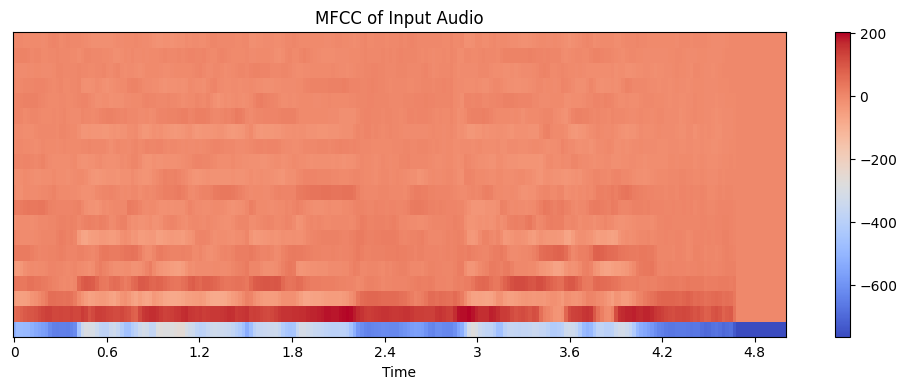

In [30]:
run_file_uploader()